# test embeddings

compare the embeddings from both MLM, genePT and scGPT

In [14]:
import pandas as pd
import scanpy as sc
import anndata as ad

In [13]:
# to see how to get scGPT's embeddings. look at the notebook Tutorial_GRN.ipynb and use the main human model
scgpt = sc.read_h5ad('../../../scGPT/save/scGPT_embeddings.h5ad')

In [2]:
# to get genePT's embeddings just download them at https://zenodo.org/records/10030426
import pickle

with open('../../data/genePT/GPT_3_5_gene_embeddings.pickle', 'rb') as f:
    gene_embeddings = pickle.load(f)

In [8]:
len(gene_embeddings), gene_embeddings['ANXA8'].shape

(33985, (1536,))

In [11]:
gene_embeddings = pd.DataFrame(gene_embeddings).T
genept = ad.AnnData(gene_embeddings)

In [50]:
# to get the ESM2 and RNABert embeddings, just see scPrint's notebooks on embeddings
esm = pd.read_parquet("../../data/temp/genesdf.parquet")
esm = ad.AnnData(X=esm.iloc[:,11:], obs=esm.iloc[:,:11])

In [51]:
rnabert = esm[esm.obs.biotype!="protein_coding"]

In [52]:
esm = esm[esm.obs.biotype=="protein_coding"]

## tests

In [53]:
sc.pp.pca(esm, n_comps=50)
sc.pp.neighbors(esm, n_neighbors=10, 
sc.tl.umap(esm, min_dist=0.5, spread=1)
sc.tl.leiden(esm)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


In [57]:
esm

AnnData object with n_obs × n_vars = 23149 × 1024
    obs: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'bionty_source_id', 'updated_at', 'created_by_id', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

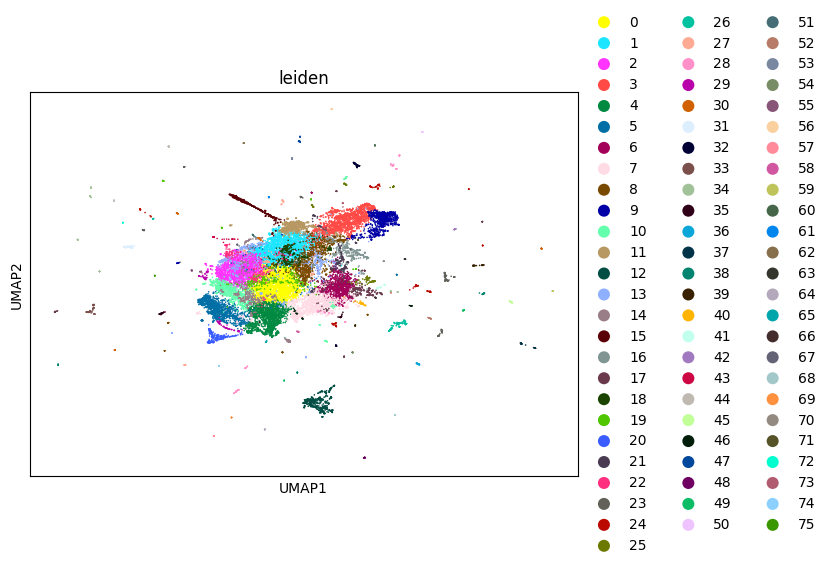

In [56]:
sc.tl.umap(esm, min_dist=0.2)
sc.pl.scatter(esm, color='leiden', basis="umap")

In [99]:
sc.pp.pca(rnabert)
sc.pp.neighbors(rnabert)
sc.tl.umap(rnabert)
sc.tl.leiden(rnabert)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


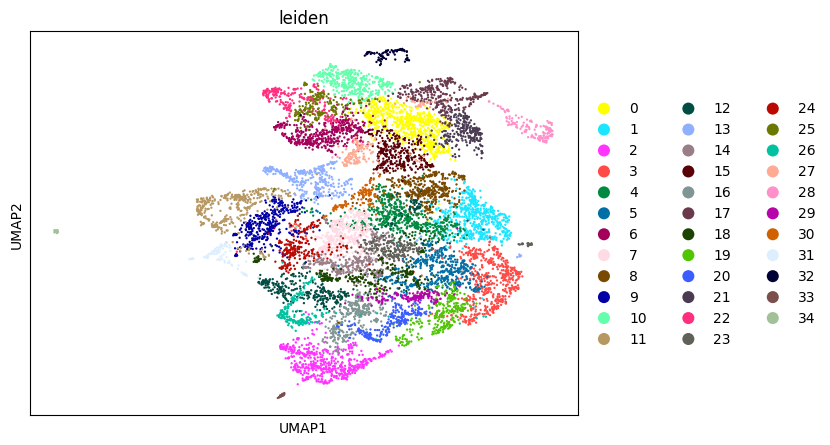

In [101]:
sc.pl.scatter(rnabert, color='leiden', basis="umap")

In [26]:
sc.pp.pca(scgpt)
sc.pp.neighbors(scgpt)
sc.tl.umap(scgpt)
sc.tl.leiden(scgpt)

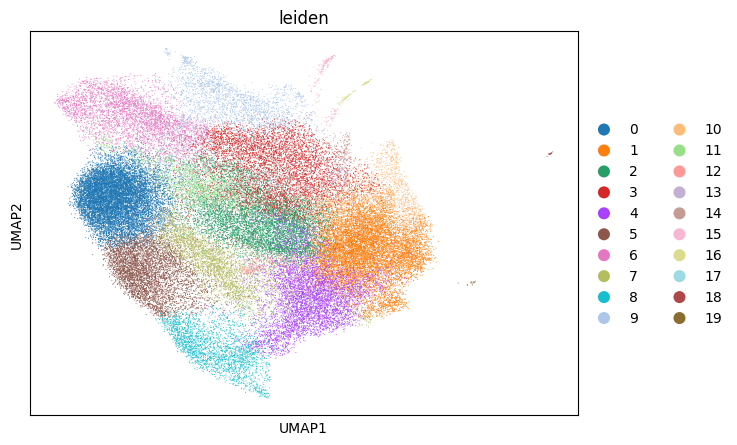

In [28]:
sc.pl.scatter(scgpt, color='leiden', basis="umap")

In [27]:
sc.pp.pca(genept)
sc.pp.neighbors(genept)
sc.tl.umap(genept)
sc.tl.leiden(genept)

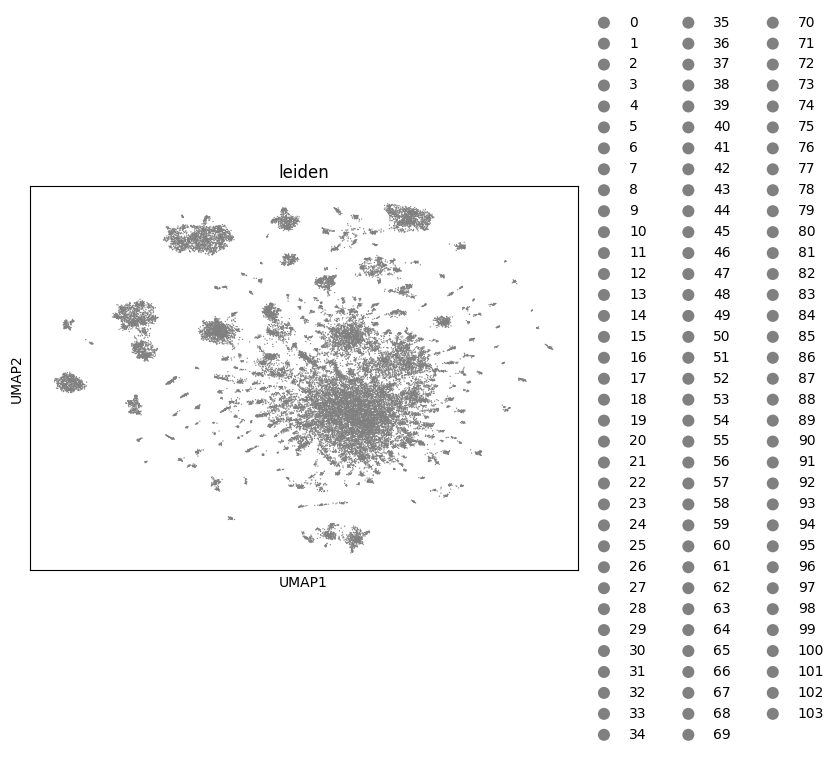

In [29]:
sc.pl.scatter(genept, color='leiden', basis="umap")

In [58]:
from gseapy import Msigdb

In [59]:
msig = Msigdb()

In [63]:
msig.list_category(dbver="2023.2.Hs")

['c1.all',
 'c2.all',
 'c2.cgp',
 'c2.cp.biocarta',
 'c2.cp.kegg_legacy',
 'c2.cp.kegg_medicus',
 'c2.cp.pid',
 'c2.cp.reactome',
 'c2.cp',
 'c2.cp.wikipathways',
 'c3.all',
 'c3.mir.mir_legacy',
 'c3.mir.mirdb',
 'c3.mir',
 'c3.tft.gtrd',
 'c3.tft.tft_legacy',
 'c3.tft',
 'c4.3ca',
 'c4.all',
 'c4.cgn',
 'c4.cm',
 'c5.all',
 'c5.go.bp',
 'c5.go.cc',
 'c5.go.mf',
 'c5.go',
 'c5.hpo',
 'c6.all',
 'c7.all',
 'c7.immunesigdb',
 'c7.vax',
 'c8.all',
 'h.all',
 'msigdb']

In [ ]:
gmt = msig.get_gmt(category='h.all', dbver="2023.2.Hs")
gmt.keys()

In [80]:
for k, val in gmt.items():
    esm.obs[k] = False
    esm.obs.loc[esm.obs.symbol.isin(val), k] = True
    scgpt.obs[k] = False
    scgpt.obs.loc[scgpt.obs.index.isin(val), k] = True
    genept.obs[k] = False
    genept.obs.loc[genept.obs.index.isin(val), k] = True

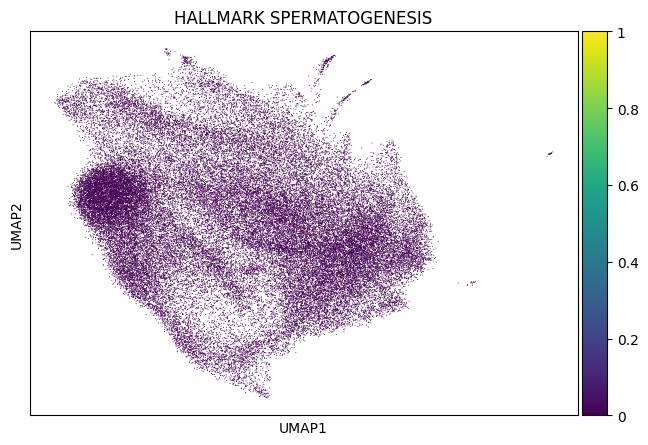

In [84]:
sc.pl.scatter(scgpt, color='HALLMARK_SPERMATOGENESIS', basis="umap")

## dimensionality of each datasets, we see that scgpt is worryingly high dimensional

In [100]:
esm.uns['pca']['variance_ratio'].sum(), scgpt.uns['pca']['variance_ratio'].sum(), genept.uns['pca']['variance_ratio'].sum(), rnabert.uns['pca']['variance_ratio'].sum()

(0.8558971020820199, 0.26194793, 0.6436582301977879, 0.9985482613667273)

In [157]:
import numpy as np
import random

def compute_sims(adata, gmt):
    from sklearn.metrics.pairwise import cosine_similarity

    cosine_sim_matrix = cosine_similarity(adata.X)
    gene_sims = 0
    for k, val in gmt.items():
        gene_indices = np.nonzero(adata.obs.symbol.isin(val).values)[0]
        if len(gene_indices) == 0:
            print("No genes found for", k)
            continue
        random_indices = random.sample(range(adata.X.shape[0]), len(gene_indices))
        gene_sim = cosine_sim_matrix[np.ix_(gene_indices, gene_indices)].mean()
        random_sim = cosine_sim_matrix[np.ix_(random_indices, random_indices)].mean()
        gene_sim = gene_sim - random_sim
        gene_sims += gene_sim
    gene_sims = gene_sims / len(gmt)
    print(gene_sims)


In [136]:
genept.obs['symbol'] = genept.obs.index
rnabert.obs['symbol'] = rnabert.obs.index
scgpt.obs['symbol'] = scgpt.obs.index

## on hallmarks, esm is best,

In [137]:
compute_sims(genept, gmt)

1.006745524835228


In [129]:
compute_sims(esm, gmt)

1.0246233852214899


In [144]:
scgpt

AnnData object with n_obs × n_vars = 60697 × 512
    obs: 'leiden', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_KRAS_SIGNALING_DN', 'HALLMARK_KRAS_SIGNALING_UP', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_MTORC1_SIGNALING', 'HALL

In [147]:
compute_sims(scgpt, gmt)

> /tmp/ipykernel_1041524/1612643785.py(14)compute_sims()
     12         import pdb
     13         pdb.set_trace()
---> 14         gene_sim = cosine_sim_matrix[np.ix_(gene_indices, gene_indices)].mean()
     15         random_sim = cosine_sim_matrix[np.ix_(random_indices, random_indices)].mean()
     16         gene_sim = gene_sim / random_sim

200
array([[ 1.0000002 , -0.04449049,  0.0101751 , ...,  0.10185738,
         0.0809833 ,  0.01858585],
       [-0.04449049,  0.99999976,  0.07976213, ...,  0.03860867,
         0.141598  ,  0.08089375],
       [ 0.0101751 ,  0.07976213,  0.9999999 , ...,  0.09676832,
         0.13369565,  0.0785964 ],
       ...,
       [ 0.10185738,  0.03860867,  0.09676832, ...,  1.0000002 ,
         0.12964904,  0.11053488],
       [ 0.0809833 ,  0.141598  ,  0.13369565, ...,  0.12964904,
         1.        ,  0.11356255],
       [ 0.01858585,  0.08089375,  0.0785964 , ...,  0.11053488,
         0.11356255,  1.        ]], dtype=float32)
0.06974787
> /tmp/ip

## on a larger set of genesets we see genept being better

In [148]:
gmt = msig.get_gmt(category='c5.go.cc', dbver="2023.2.Hs")

In [151]:
compute_sims(genept, gmt)

0.03798989604577959


In [152]:
compute_sims(scgpt, gmt)

0.011655040232125173


In [156]:
compute_sims(esm, gmt)

0.02298365160422277
